In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# parameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 20
img_size = 64


cuda


In [2]:
data = np.load('data/bouncing_mnist_test.npy')
data = data.reshape((200000,1,64,64))
data = data / 255 # normalize pixel value between 0 and 1

train_loader = torch.utils.data.DataLoader(
                 dataset=data,
                 batch_size=128,
                 shuffle=True)

In [3]:
class VAE(nn.Module):
    def __init__(self, img_size=64, latent_dim=16,nb_output_channel=32):
        super(VAE, self).__init__()

        self.nb_output_channel = nb_output_channel

        self.featureDim = (img_size - 8)*(img_size - 8)*self.nb_output_channel
        self.featurePooledDim = self.nb_output_channel*14*14
        self.hiddenDim = 128
        self.latentDim = latent_dim
        
        self.indices = None

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(1, self.nb_output_channel//2, 5)
        self.encConv2 = nn.Conv2d(self.nb_output_channel//2, self.nb_output_channel, 5) 
        self.maxpool = nn.MaxPool2d(4,return_indices=True)
        self.encFC = nn.Linear(self.featurePooledDim, self.hiddenDim)
        self.encFC1 = nn.Linear(self.hiddenDim, self.latentDim)
        self.encFC2 = nn.Linear(self.hiddenDim, self.latentDim)
        
        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC = nn.Linear(self.latentDim, self.hiddenDim)
        self.decFC1 = nn.Linear(self.hiddenDim, self.featurePooledDim)
        self.maxunpool = nn.MaxUnpool2d(4)
        self.decConv1 = nn.ConvTranspose2d(self.nb_output_channel, self.nb_output_channel//2, 5)
        self.decConv2 = nn.ConvTranspose2d(self.nb_output_channel//2, 1, 5)
        
    def encoder(self, x):
        
        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x,indices = self.maxpool(x)
        self.indices = indices
        x = x.view(-1, self.featurePooledDim)
        x = F.relu(self.encFC(x))
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar
    
    def reparameterize(self, mu, logVar):
        
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decoder(self, z):
        
        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC(z))
        x = F.relu(self.decFC1(x))
        x = x.view(-1, self.nb_output_channel, 14, 14)
        x = self.maxunpool(x,indices=self.indices)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x
        
    def forward(self, x):
        
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

In [4]:
net = VAE().to(device)
print('nb of params : {}'.format(count_parameters(net)))

nb of params : 1644801


In [5]:
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [9]:
from tqdm import tqdm

for epoch in range(num_epochs):

    pbar = tqdm(train_loader)
    pbar.set_description("epoch %s/ loss=? " % str(epoch+1))
    
    for data in pbar:
        
        imgs = data
        imgs = imgs.to(device).float()
        
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)
        
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description("epoch "+str(epoch+1)+"/"+str(num_epochs)+"/ loss= "+str(loss.cpu().detach().numpy()) )
        
        

epoch 1/ loss=? :   0%|          | 0/1563 [00:00<?, ?it/s]c:\Users\fphub\mambaforge\envs\iblenv\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
epoch 2/20/ loss= 14866.904:  42%|████▏     | 662/1563 [00:41<00:56, 16.01it/s] 


KeyboardInterrupt: 

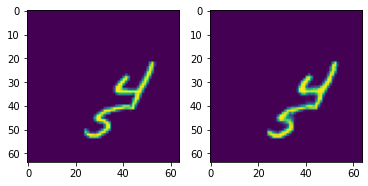

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
with torch.no_grad():
    for data in random.sample(list(train_loader), 1):
        imgs = data
        imgs = imgs.to(device).float()
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))

In [16]:
torch.save(net.state_dict(), 'vae_moving_digits.pt')

In [17]:
net = VAE().to(device)
net.load_state_dict(torch.load('vae_moving_digits.pt'))
net.eval()

VAE(
  (encConv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (encConv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (encFC): Linear(in_features=100352, out_features=256, bias=True)
  (encFC1): Linear(in_features=256, out_features=16, bias=True)
  (encFC2): Linear(in_features=256, out_features=16, bias=True)
  (decFC): Linear(in_features=16, out_features=256, bias=True)
  (decFC1): Linear(in_features=256, out_features=100352, bias=True)
  (decConv1): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (decConv2): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(1, 1))
)

In [23]:
net

VAE(
  (encConv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (encConv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (encFC): Linear(in_features=6272, out_features=128, bias=True)
  (encFC1): Linear(in_features=128, out_features=16, bias=True)
  (encFC2): Linear(in_features=128, out_features=16, bias=True)
  (decFC): Linear(in_features=16, out_features=128, bias=True)
  (decFC1): Linear(in_features=128, out_features=100352, bias=True)
  (decConv1): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (decConv2): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(1, 1))
)